# Librerias comunes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importacion datos

In [2]:
from mongo_local_module import connect_to_db, get_collection_as_dataframe

## Conectar a db

In [3]:
db_name = 'ds_market'         # Nombre de la base de datos

# Conectar a la base de datos
db = connect_to_db(db_name, local=True)

Conexión exitosa


## Obtener colecciones

In [4]:
# Diccionario colecciones
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

In [5]:
df_cal = get_collection_as_dataframe(db, 'calendar').drop(columns='_id')
# Se añadieron columnas week y month a calendar para hacer cruces de datos mas faciles

df_cal = df_cal.fillna('None') # event tiene NaN

display(df_cal.head())

El número de documentos en la colección 'calendar' es: 1913


,date,weekday,weekday_int,d,event,month,week
0,2011-01-29,Saturday,1,d_1,None,1,4
1,2011-01-30,Sunday,2,d_2,None,1,4
2,2011-01-31,Monday,3,d_3,None,1,5
3,2011-02-01,Tuesday,4,d_4,None,2,5
4,2011-02-02,Wednesday,5,d_5,None,2,5


In [6]:
df_shops = get_collection_as_dataframe(db, 'tiendas').drop(columns='_id')
df_items = get_collection_as_dataframe(db, 'items').drop(columns='_id')

df_ws = get_collection_as_dataframe(db, 'weekly_sales').drop(columns='_id')

# Añadimos eventos para no perder esa información
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()

# Añadir la columna 'event' a df_ws usando el método 'map'
df_ws['event'] = df_ws['week'].map(event_dict)

El número de documentos en la colección 'tiendas' es: 10
El número de documentos en la colección 'items' es: 3049
El número de documentos en la colección 'weekly_sales' es: 5016091


# Clustering productos

## Creacion caracteristicas

In [7]:
import feature_creation_module as fcm

In [8]:
# DataFrames de entrada
feature_matrix = fcm.create_features(df_items, df_shops, df_ws)

# Renombrar características si es necesario
feature_matrix_renamed = fcm.rename_features(feature_matrix)

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, fall

<Feature: category>: The "category".
<Feature: department>: The "department".
<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "item" in "items".
<Feature: STD(sales.raw_earn)>: The standard deviation of the "raw_earn" of all instances of "sales" for each "item" in "items".
<Feature: STD(sales.sell_price)>: The standard deviation of the "sell_price" of all instances of "sales" for each "item" in 

**Desviación estándar de las semanas de venta (`STD(sales.week)`):**  

Esta métrica revela si las ventas de un producto están concentradas en ciertos períodos del año o dispersas. Un alto valor indica ventas distribuidas, mientras que un valor bajo sugiere un patrón estacional claro. Esto es útil para identificar productos estacionales.

**Media de los años de venta (`MEAN(sales.year)`):**  

La media de los años de venta muestra cuándo los productos han sido más populares, ayudando a detectar si una tendencia es reciente o si un producto está en declive. Esto facilita el agrupamiento de productos según su ciclo de vida y relevancia actual.

**Media de las semanas de venta (`MEAN(sales.week)`):**  

Esta métrica indica en qué parte del año un producto suele venderse más. Permite agrupar productos según su popularidad en diferentes épocas, ayudando a identificar patrones estacionales y planificar estrategias de ventas e inventario.

In [9]:
feature_matrix_renamed.head(10)

,Num Sales,Total Units Sold,Total Revenue,Avg Sell Price,Std Sell Price,Std Units Sold,Avg Units Per Week,Avg Week,Std Week,Avg Year
item,,,,,,,,,,
ACCESORIES_1_001,1185,4093.0,44559.7348,11.012286,0.187744,2.236397,3.454008,27.129114,15.691742,2014.459916
ACCESORIES_1_002,1899,5059.0,26639.4744,5.276624,0.090513,2.209479,2.664034,27.790416,15.150502,2013.292786
ACCESORIES_1_003,665,1435.0,5533.7310,3.937700,0.182242,1.626411,2.157895,23.950376,15.015021,2014.908271
ACCESORIES_1_004,2512,39175.0,234283.9156,5.985903,0.266703,12.957875,15.595143,25.860669,15.162379,2013.216959
ACCESORIES_1_005,2134,14621.0,55310.5903,3.825727,0.227320,4.942326,6.851453,27.065136,15.363908,2013.463449
ACCESORIES_1_006,1736,13068.0,17288.1912,1.334689,0.053361,6.137553,7.527650,25.953341,14.985165,2013.744240
ACCESORIES_1_007,1428,3014.0,31327.2190,10.478880,0.155090,1.304544,2.110644,27.012605,15.763711,2014.044118
ACCESORIES_1_008,2375,87645.0,55054.6850,0.630134,0.025067,29.747971,36.903158,25.042526,15.051956,2013.376842
ACCESORIES_1_009,2319,15657.0,35707.9996,2.290563,0.101603,5.090507,6.751617,25.885295,15.213231,2013.226822


## Preprocesamiento de los datos

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.exceptions import NotFittedError

def preprocess_features(feature_matrix):
    try:
        # Identificar columnas categóricas y numéricas
        categorical_columns = feature_matrix.select_dtypes(include=['object', 'category']).columns.tolist()
        numeric_columns = feature_matrix.select_dtypes(include=[float, int]).columns.tolist()

        print(f'Cat cols: {len(categorical_columns)}')
        print(f'Num cols: {len(numeric_columns)}')

        # Definir la lista de transformadores
        transformers = []
        
        # Agregar el RobustScaler para las columnas numéricas si existen
        if numeric_columns:
            transformers.append(('num', RobustScaler(), numeric_columns))
        
        # Agregar el OneHotEncoder para las columnas categóricas si existen
        if categorical_columns:
            transformers.append(('cat', OneHotEncoder(drop='first', sparse=False), categorical_columns))

        # Crear el preprocesador con los transformadores existentes
        preprocessor = ColumnTransformer(transformers)

        # Aplicar las transformaciones utilizando el preprocesador
        scaled_features = preprocessor.fit_transform(feature_matrix)

        # Obtener el nombre de las columnas después de la transformación
        all_columns = numeric_columns.copy()  # Empezamos con las columnas numéricas

        if categorical_columns:
            encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
            all_columns += encoded_columns.tolist()

        # Convertir el resultado de nuevo a un DataFrame
        scaled_df = pd.DataFrame(scaled_features, columns=all_columns)

        # Devolver el DataFrame transformado
        return scaled_df
    
    except NotFittedError as e:
        print(f"Error: {e}")
        return None

# Uso
# scaled_df = preprocess_features(fm_selected_sales)

In [11]:
scaled_df = preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 10


In [12]:
scaled_df.head()

,Num Sales,Total Units Sold,Total Revenue,Avg Sell Price,Std Sell Price,Std Units Sold,Avg Units Per Week,Avg Week,Std Week,Avg Year
0,-0.496040,-0.317794,0.024548,1.500101,0.214006,-0.352174,-0.299973,1.093335,0.696325,0.967864
1,0.210891,-0.261289,-0.265924,0.241148,-0.233545,-0.356651,-0.399820,1.742089,-0.211576,-0.182634
2,-1.010891,-0.473269,-0.608030,-0.052740,0.188680,-0.453624,-0.463792,-2.025088,-0.438839,1.409830
3,0.817822,1.734265,3.099809,0.396832,0.577454,1.430975,1.234579,-0.151042,-0.191653,-0.257381
4,0.443564,0.298023,0.198809,-0.077317,0.396175,0.097864,0.129440,1.030571,0.146401,-0.014403


## Kmeans

In [13]:
import kmeans_module as km_m

### Elbow & Silouette

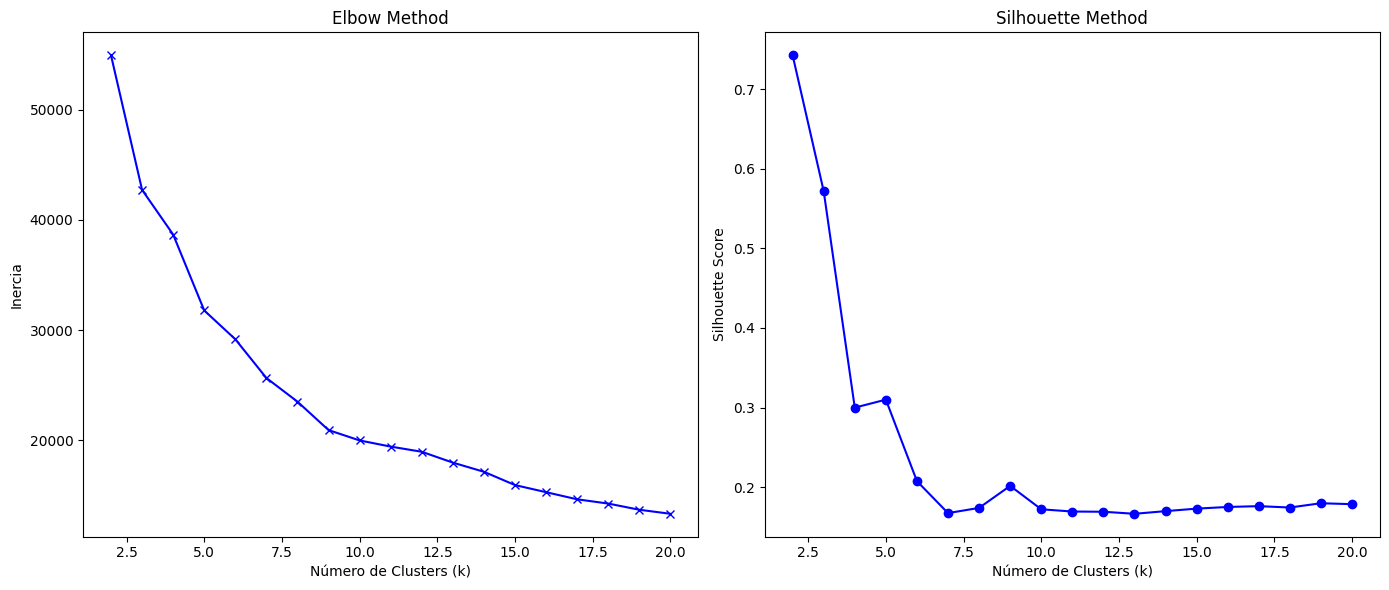

In [14]:
km_m.plot_elbow_silhouette(scaled_df, 20)

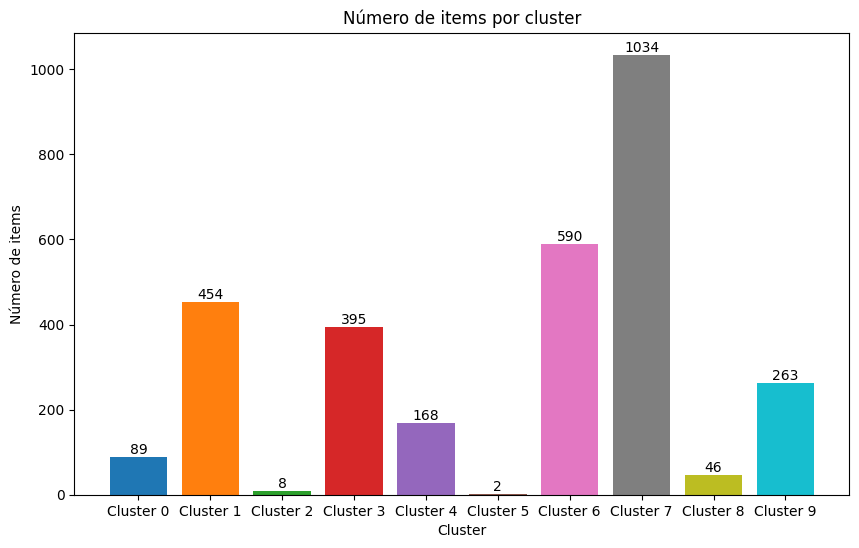

,Num Sales,Total Units Sold,Total Revenue,Avg Sell Price,Std Sell Price,Std Units Sold,Avg Units Per Week,Avg Week,Std Week,Avg Year,Cluster
item,,,,,,,,,,,
ACCESORIES_1_001,1185,4093.0,44559.7348,11.012286,0.187744,2.236397,3.454008,27.129114,15.691742,2014.459916,6
ACCESORIES_1_002,1899,5059.0,26639.4744,5.276624,0.090513,2.209479,2.664034,27.790416,15.150502,2013.292786,6
ACCESORIES_1_003,665,1435.0,5533.7310,3.937700,0.182242,1.626411,2.157895,23.950376,15.015021,2014.908271,7
ACCESORIES_1_004,2512,39175.0,234283.9156,5.985903,0.266703,12.957875,15.595143,25.860669,15.162379,2013.216959,1
ACCESORIES_1_005,2134,14621.0,55310.5903,3.825727,0.227320,4.942326,6.851453,27.065136,15.363908,2013.463449,7


In [15]:
optimal_k = 10 # Segun silueta

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

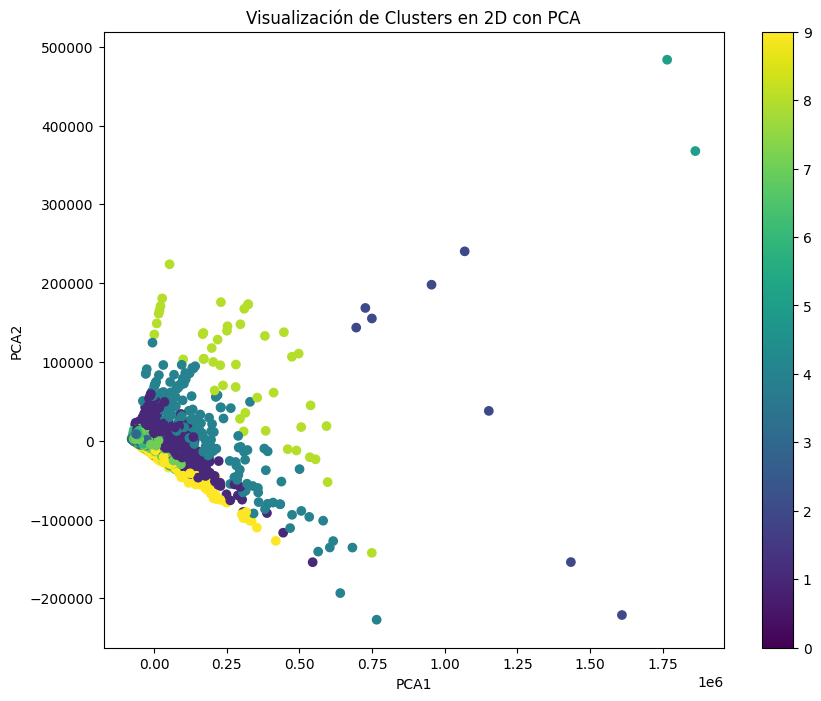

,PCA1,PCA2,Cluster
0,-34520.502209,-7649.051664,6
1,-51364.408632,-1458.831991,6
2,-72605.810513,1276.347614,7
3,157139.320801,-29860.025049,1
4,-21148.885107,-742.953076,7


In [16]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 0.94
Principal Component 2: 0.06
Principal Component 3: 0.00
Principal Component 4: 0.00
Principal Component 5: 0.00
Principal Component 6: 0.00
Principal Component 7: 0.00
Principal Component 8: 0.00
Principal Component 9: 0.00
Principal Component 10: 0.00
Principal Component 11: 0.00


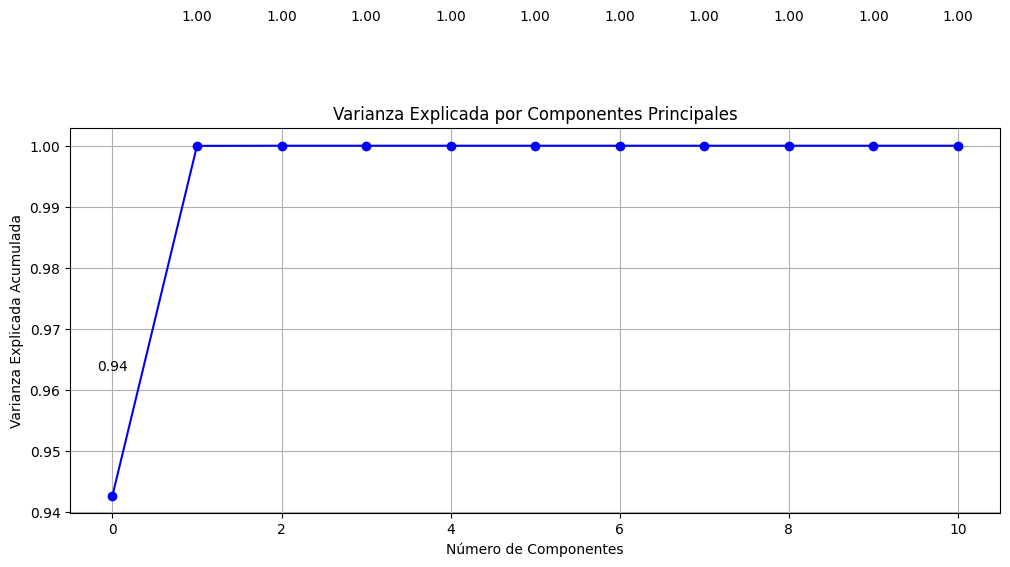

array([9.42719351e-01, 5.72593061e-02, 2.13385537e-05, 2.67839215e-09,
       1.06730245e-09, 3.51543727e-10, 3.30393523e-10, 9.05249784e-11,
       4.76562824e-11, 9.43097259e-12, 3.05945902e-12])

In [17]:
km_m.pca_variance_plot(feature_matrix_with_clusters)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 10


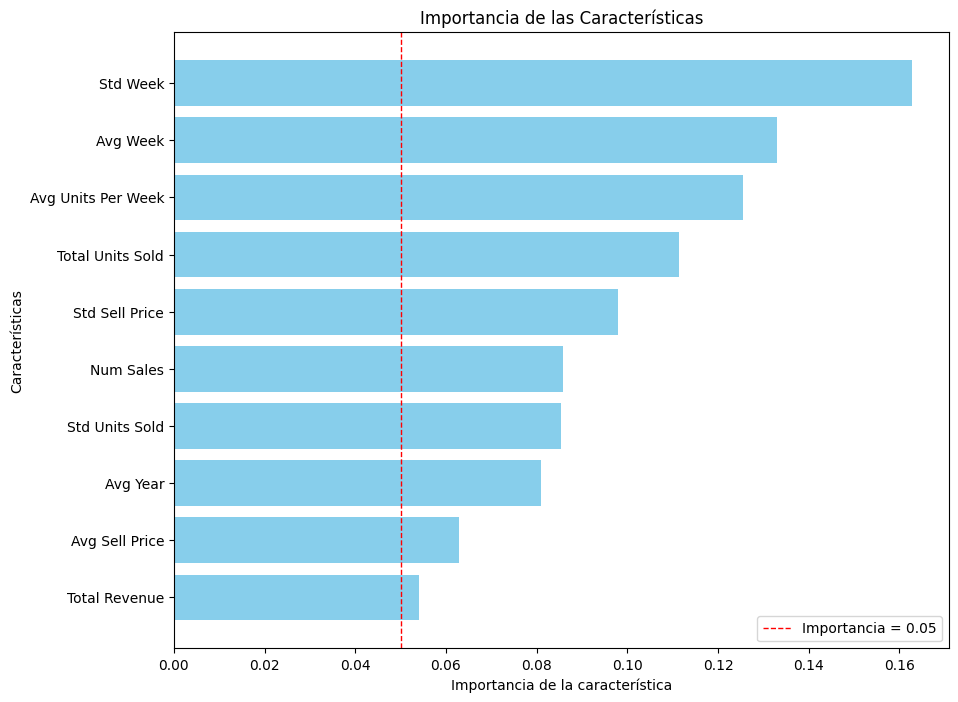

,Feature,Importance
0,Std Week,0.162772
1,Avg Week,0.133066
2,Avg Units Per Week,0.125588
3,Total Units Sold,0.111467
4,Std Sell Price,0.097904
5,Num Sales,0.085824
6,Std Units Sold,0.085310
7,Avg Year,0.080969
8,Avg Sell Price,0.062955
9,Total Revenue,0.054145


In [18]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

# sales_importance_df = km_m.get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
sales_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=0.05)

display(sales_importance_df.head(10))

### Dimension Redux

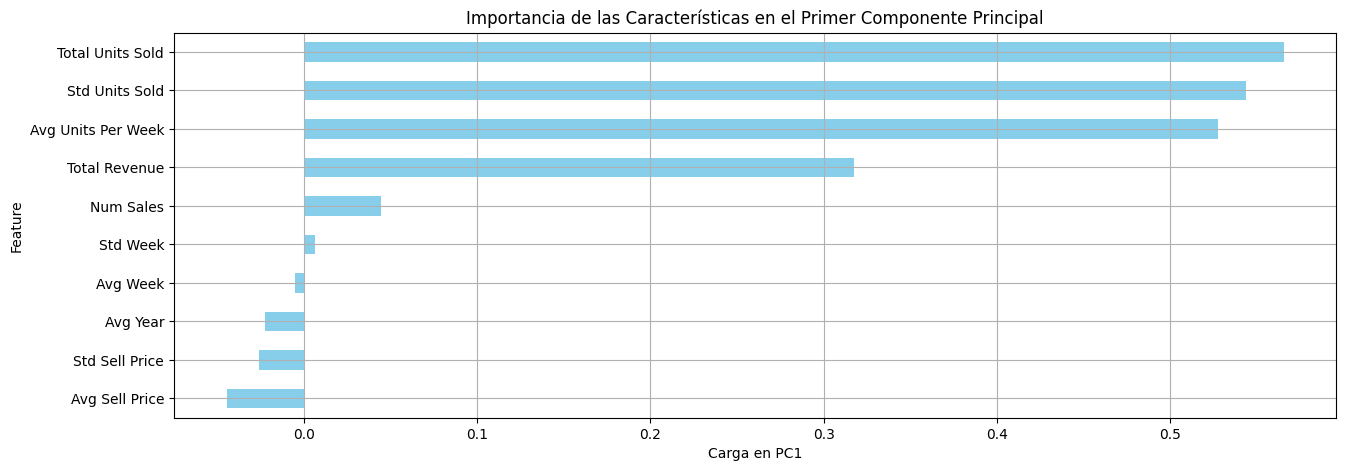

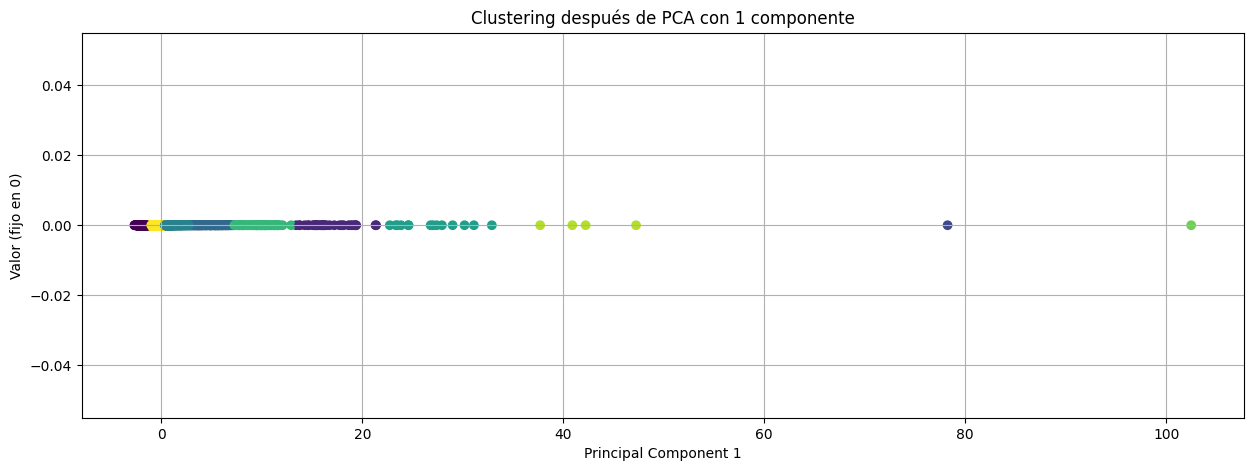

In [19]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

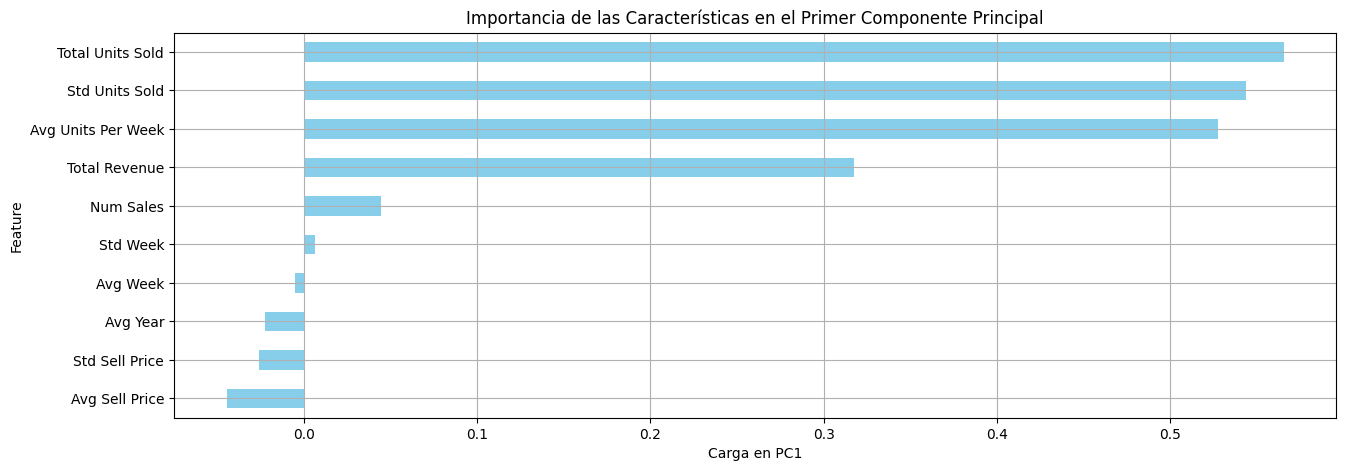

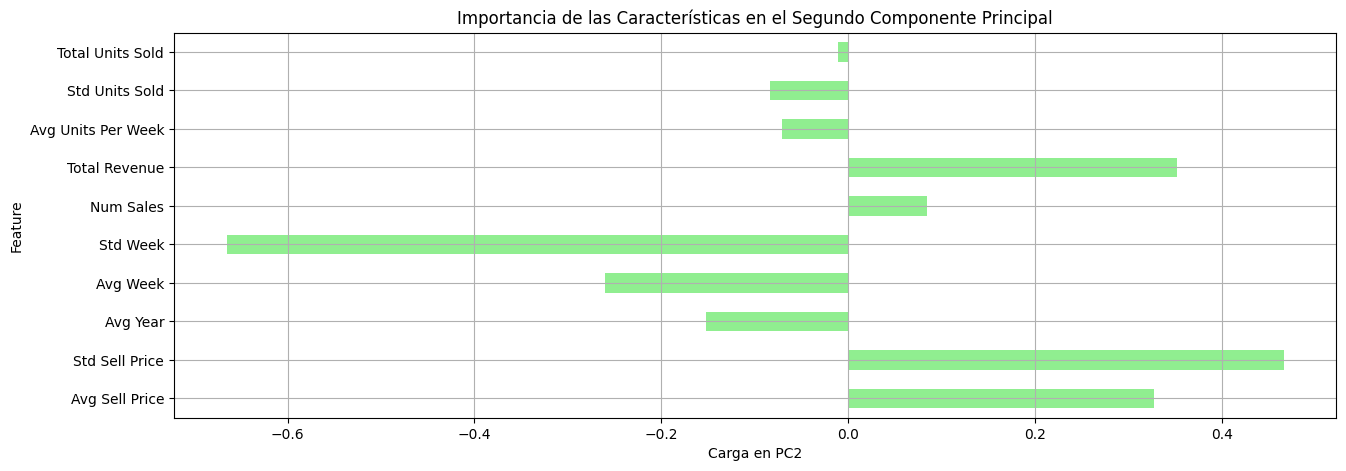

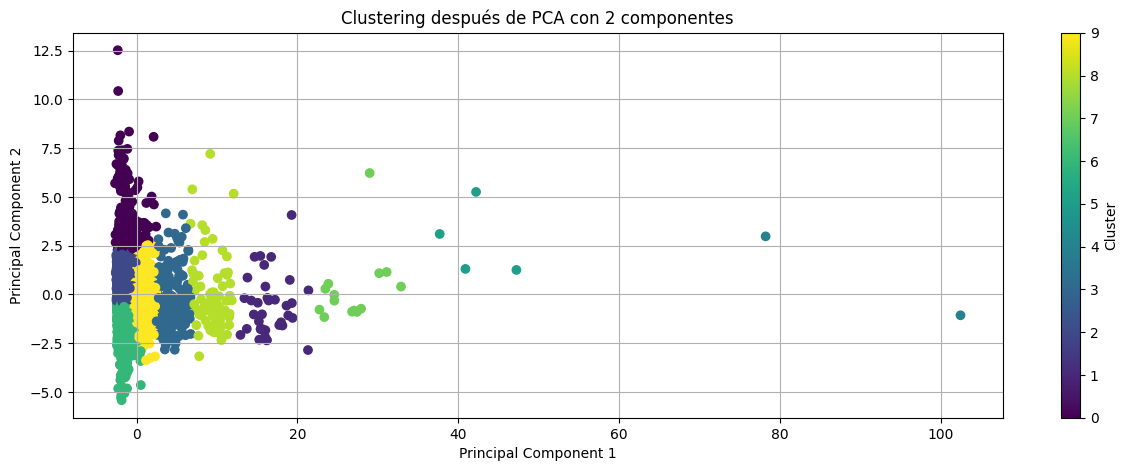

In [20]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## CLUSTERING MODULE

In [21]:
import clustering_module as cm

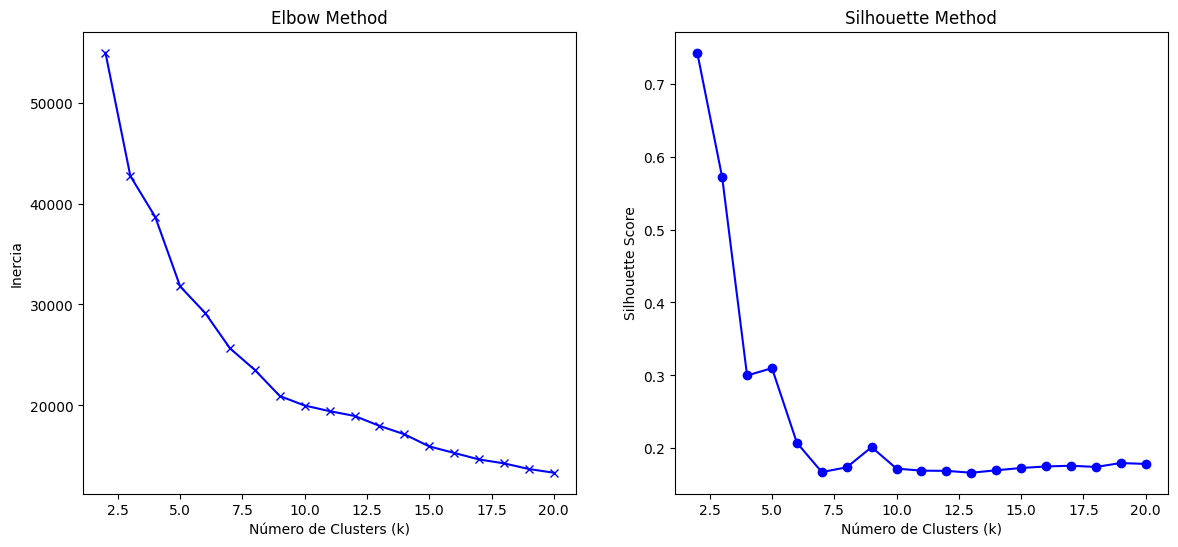

Cargas de PCA:
                         PC1       PC2
Num Sales           0.044275  0.084154
Total Units Sold    0.565438 -0.011159
Total Revenue       0.317766  0.351438
Avg Sell Price     -0.044554  0.327400
Std Sell Price     -0.025743  0.465992
Std Units Sold      0.543630 -0.083537
Avg Units Per Week  0.527807 -0.071039
Avg Week           -0.005371 -0.259917
Std Week            0.006652 -0.665081
Avg Year           -0.022589 -0.151758

Contribuciones de las características a cada componente PCA:
                         PC1       PC2
Num Sales           0.001960  0.007082
Total Units Sold    0.319720  0.000125
Total Revenue       0.100975  0.123509
Avg Sell Price      0.001985  0.107191
Std Sell Price      0.000663  0.217148
Std Units Sold      0.295533  0.006978
Avg Units Per Week  0.278580  0.005047
Avg Week            0.000029  0.067557
Std Week            0.000044  0.442333
Avg Year            0.000510  0.023030


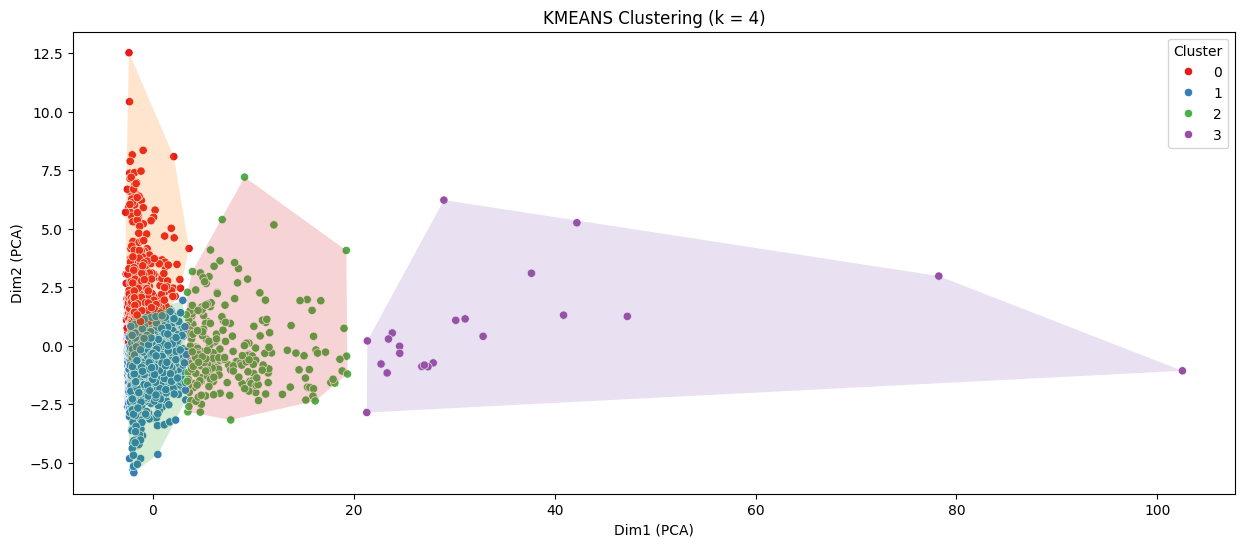

In [22]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    feature_matrix_renamed, method='kmeans', n_clusters=4
)

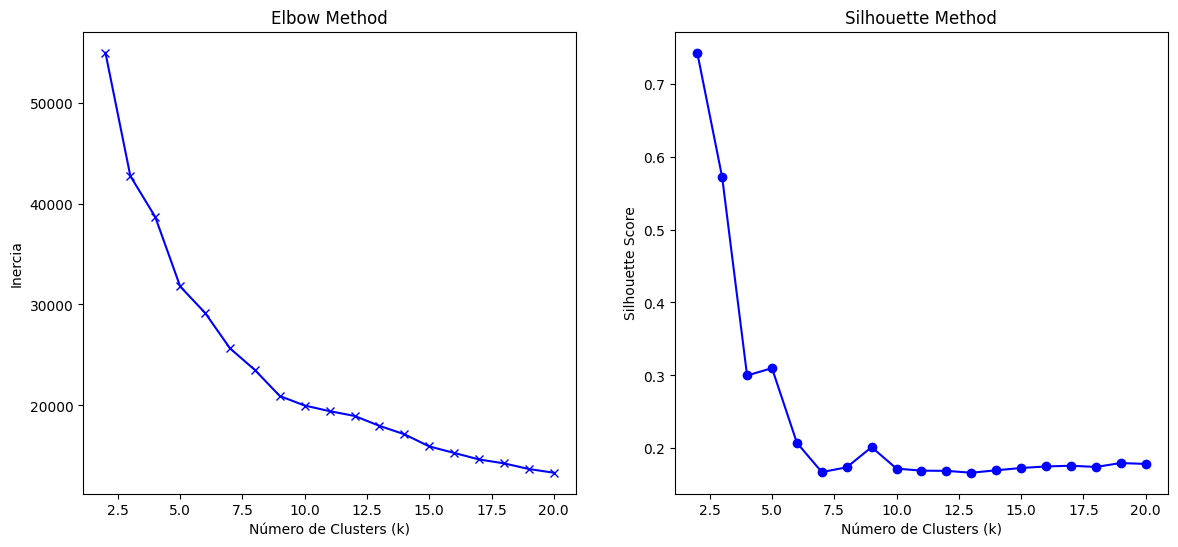

Cargas de PCA:
                         PC1       PC2
Num Sales           0.044275  0.084154
Total Units Sold    0.565438 -0.011159
Total Revenue       0.317766  0.351438
Avg Sell Price     -0.044554  0.327400
Std Sell Price     -0.025743  0.465992
Std Units Sold      0.543630 -0.083537
Avg Units Per Week  0.527807 -0.071039
Avg Week           -0.005371 -0.259917
Std Week            0.006652 -0.665081
Avg Year           -0.022589 -0.151758

Contribuciones de las características a cada componente PCA:
                         PC1       PC2
Num Sales           0.001960  0.007082
Total Units Sold    0.319720  0.000125
Total Revenue       0.100975  0.123509
Avg Sell Price      0.001985  0.107191
Std Sell Price      0.000663  0.217148
Std Units Sold      0.295533  0.006978
Avg Units Per Week  0.278580  0.005047
Avg Week            0.000029  0.067557
Std Week            0.000044  0.442333
Avg Year            0.000510  0.023030


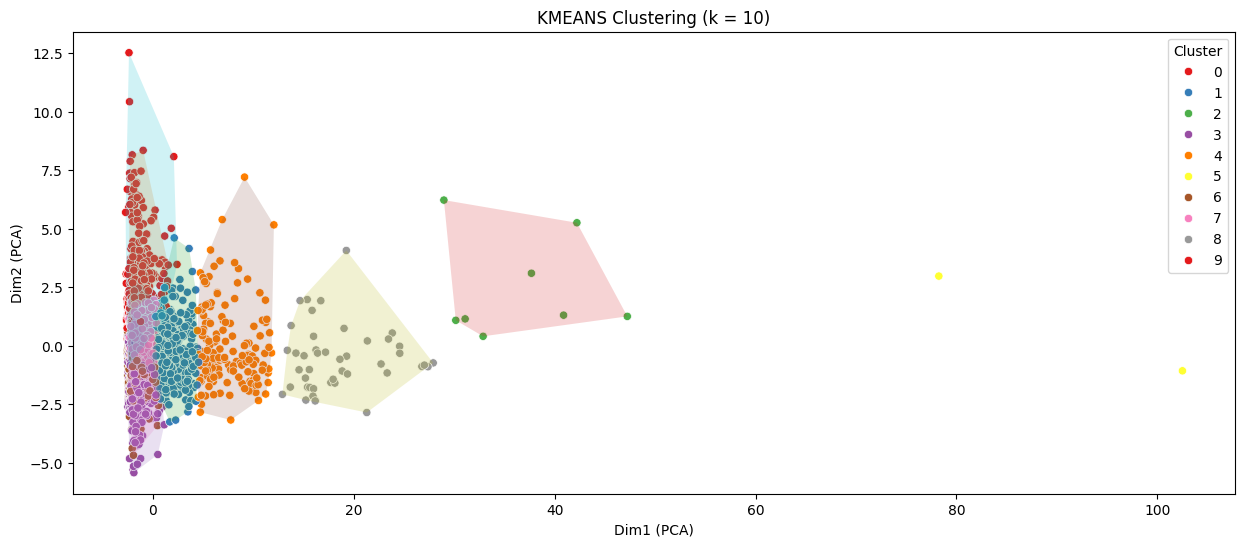

In [23]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    preprocessed_df, method='kmeans', n_clusters=optimal_k
)

c:\Users\alexa\Documents\GitHub\TFM_Retail\grupo2retail_0424\03_Clustering\clustering_module.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


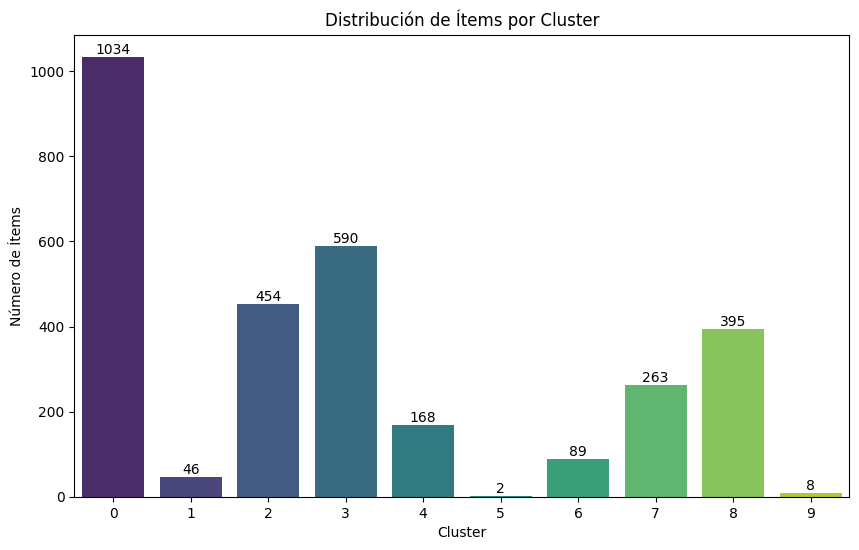

c:\Users\alexa\Documents\GitHub\TFM_Retail\grupo2retail_0424\03_Clustering\clustering_module.py:216: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data.columns, x=importances, palette='viridis')


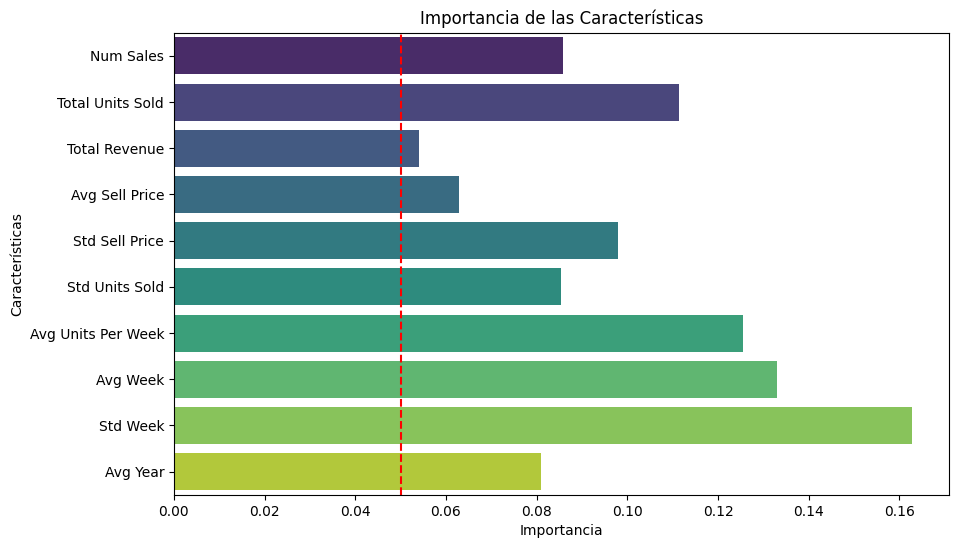

Cluster                    0          1         2         3         4  \
Num Sales           0.236570   0.499570  0.358830 -0.518609  0.449605   
Total Units Sold    0.091720  10.834902  1.585831 -0.207240  4.549743   
Total Revenue       0.138022   4.689701  1.222112 -0.318967  3.109106   
Avg Sell Price      0.249240  -0.505274 -0.143410  0.116061 -0.194069   
Std Sell Price      0.198816  -0.234935  0.012721 -0.166330  0.028842   
Std Units Sold     -0.050835  11.724050  1.579099 -0.156074  4.832285   
Avg Units Per Week -0.040318  10.650111  1.577867 -0.127987  4.459419   
Avg Week           -0.203682  -0.123454  0.052767  1.024816 -0.068043   
Std Week           -0.356479  -0.125944  0.191603  0.105281  0.165591   
Avg Year           -0.079730  -0.048909  0.066161  0.688486 -0.012102   

Cluster                     5         6         7         8          9  
Num Sales            0.783168 -0.426154 -0.113327 -0.667916   0.830817  
Total Units Sold    55.677322 -0.133006 -0.102184 

In [24]:
kmeans_cluster_labels, kmeans_cluster_summary = cm.perform_clustering_analysis(preprocessed_df, n_clusters=optimal_k)

In [25]:
# display(kmeans_cluster_labels)

In [26]:
display(kmeans_cluster_summary)

Cluster,0,1,2,3,4,5,6,7,8,9
Num Sales,0.236570,0.499570,0.358830,-0.518609,0.449605,0.783168,-0.426154,-0.113327,-0.667916,0.830817
Total Units Sold,0.091720,10.834902,1.585831,-0.207240,4.549743,55.677322,-0.133006,-0.102184,-0.166381,22.699352
Total Revenue,0.138022,4.689701,1.222112,-0.318967,3.109106,26.600539,-0.124256,1.043740,-0.255795,16.432979
Avg Sell Price,0.249240,-0.505274,-0.143410,0.116061,-0.194069,-0.526379,0.365700,2.326488,0.201101,-0.273211
Std Sell Price,0.198816,-0.234935,0.012721,-0.166330,0.028842,-0.116460,0.576294,2.998195,-0.037933,-0.043192
Std Units Sold,-0.050835,11.724050,1.579099,-0.156074,4.832285,47.278061,0.107276,-0.136921,0.075816,17.293510
Avg Units Per Week,-0.040318,10.650111,1.577867,-0.127987,4.459419,49.151776,-0.002367,-0.149867,0.062623,19.253999
Avg Week,-0.203682,-0.123454,0.052767,1.024816,-0.068043,-0.162571,-2.139888,-0.129964,-0.514900,-0.129521
Std Week,-0.356479,-0.125944,0.191603,0.105281,0.165591,-0.052394,-5.399951,-0.111786,1.780979,-0.026853
Avg Year,-0.079730,-0.048909,0.066161,0.688486,-0.012102,-0.159374,0.102708,0.181200,0.945753,-0.162340
